Shape: (11162, 17)
Columns: Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown  

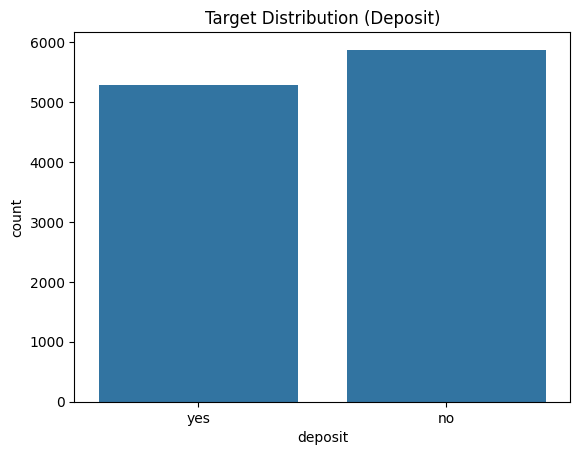


Logistic Regression Report:
              precision    recall  f1-score   support

          no       0.82      0.85      0.84      1175
         yes       0.83      0.80      0.81      1058

    accuracy                           0.83      2233
   macro avg       0.83      0.82      0.82      2233
weighted avg       0.83      0.83      0.83      2233



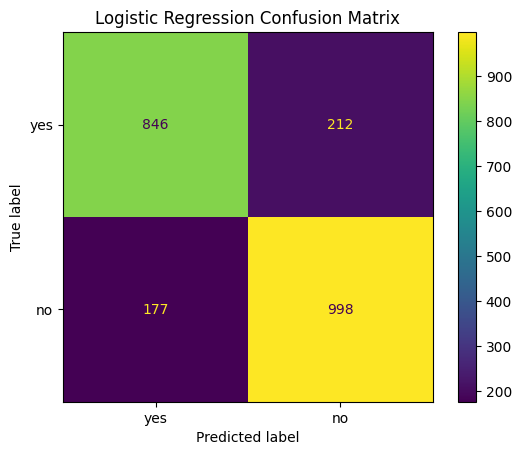

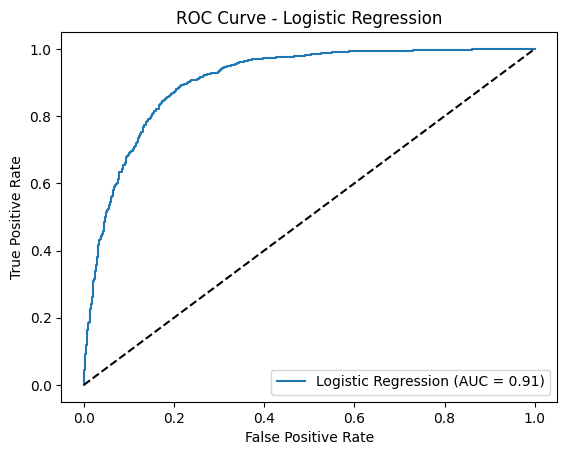


Random Forest Report:
              precision    recall  f1-score   support

          no       0.89      0.83      0.86      1175
         yes       0.83      0.89      0.86      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233



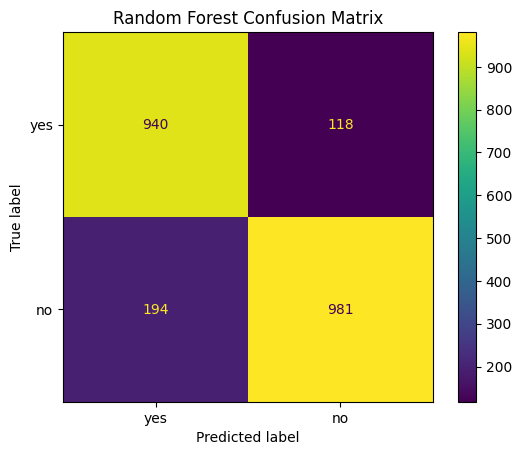

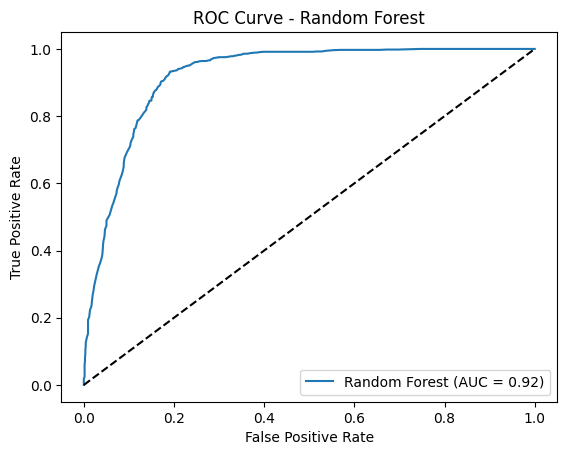

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

import shap


df = pd.read_csv("bank.csv", sep=",")

print("Shape:", df.shape)
print("Columns:", df.columns)
print(df.head())

#Target distribution

print("\nTarget distribution:")
print(df["deposit"].value_counts())

sns.countplot(x="deposit", data=df)
plt.title("Target Distribution (Deposit)")
plt.show()

#Preprocessing

X = df.drop("deposit", axis=1)
y = df["deposit"]

# Encode categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Logistic Regression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["yes", "no"])
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["yes", "no"]).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ROC Curve
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.map({"no":0, "yes":1}), y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

#Random Forest

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["yes", "no"])
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["yes", "no"]).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.map({"no":0, "yes":1}), y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()


# Explainability with SHAP

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Feature importance
shap.summary_plot(shap_values[1], X_test)

# Explain 5 predictions
for i in range(5):
    print(f"\n--- SHAP Explanation for Test Sample {i} ---")
    shap.force_plot(explainer.expected_value[1],
                    shap_values[1][i, :],
                    X_test.iloc[i, :],
                    matplotlib=True)
